In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn



In [2]:
tree = Tree(fc.eightb.training.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)

In [5]:
jet_features = ["jet_ptRegressed",
                "jet_mRegressed",
                "jet_eta",
                "jet_phi",
                "jet_btag"]

dijet_features = ["dijet_pt",
                "dijet_m",
                "dijet_eta",
                "dijet_phi",
                "dijet_dr"]

In [6]:
def yaml_format(*args):
    args = ', '.join([ str(a) for a in args])
    print(f'- [{args}]')

In [7]:
[ yaml_format(f, ak.mean(tree[f]),1/ak.std(tree[f])) for f in jet_features ]

- [jet_ptRegressed, 106.55936421260857, 0.011118355481075155]
- [jet_mRegressed, 13.853770327876914, 0.0755844623276882]
- [jet_eta, -0.002372181503862679, 0.9492485329219156]


KeyboardInterrupt: 

In [ ]:
[ yaml_format(f, 0, ak.max(np.abs(tree[f]))) for f in jet_features ]

- [jet_ptRegressed, 0, 3693.0356]
- [jet_mRegressed, 0, 338.35437]
- [jet_eta, 0, 2.4995117]
- [jet_phi, 0, 3.1415837]
- [jet_btag, 0, 0.9995117]


[None, None, None, None, None]

In [ ]:
[ yaml_format(f,ak.mean(tree[f]),1/ak.std(tree[f])) for f in dijet_features ]

- [dijet_pt, 149.8609226372421, 0.009102197117762117]
- [dijet_m, 186.06887703117806, 0.007105258302755634]
- [dijet_eta, -0.0066939666656760785, 0.7784110377705377]
- [dijet_phi, -0.0006699702615941042, 0.5504368021912591]
- [dijet_dr, 2.140659578875161, 1.1508677128601401]


[None, None, None, None, None]

In [ ]:
[ yaml_format(f, 0, 1/ak.max(np.abs(tree[f]))) for f in dijet_features ]

- [dijet_pt, 0, 0.00026392446399364105]
- [dijet_m, 0, 0.00023999677504333536]
- [dijet_eta, 0, 0.1060922914790035]
- [dijet_phi, 0, 0.3183102155222888]
- [dijet_dr, 0, 0.1730893684693315]


[None, None, None, None, None]

In [ ]:
n_tru = ak.sum(tree.dijet_signalId>-1)
n_fak = ak.sum(tree.dijet_signalId==-1)

In [ ]:
class_weights = np.array([n_tru,n_fak])

In [ ]:
class_weights.max()/class_weights

array([13.30827379,  1.        ])

In [13]:
nfound = Histo(tree.nfound_presel, density=True)

(<Figure size 468x468 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

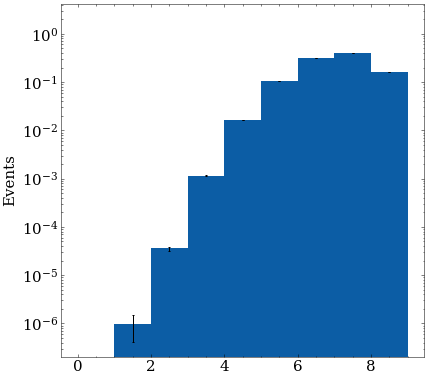

In [14]:
plot_histo(nfound, log=True)

In [55]:
bins = nfound.bins
event_weights = -np.log(nfound.histo*bins[:-1])

In [56]:
x = np.arange(9)
y = np.interp(x, bins[1:-1], event_weights[1:])
y /= y.min()

(<Figure size 468x468 with 1 Axes>, <AxesSubplot:>)

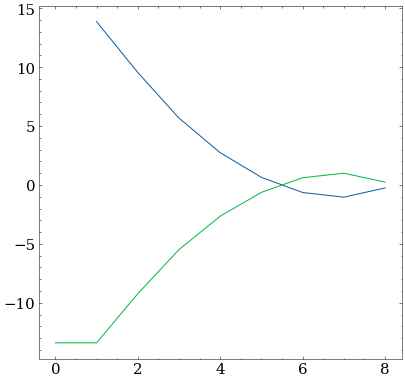

In [57]:

graph_arrays([x, x],[event_weights, y])

(<Figure size 468x468 with 1 Axes>, <AxesSubplot:>)

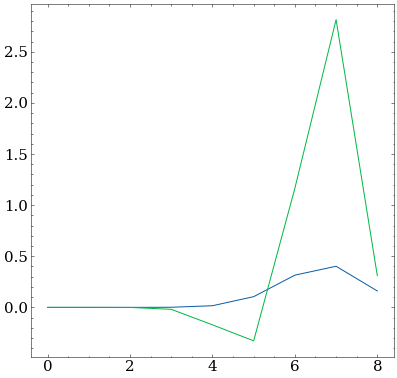

In [60]:
graph_arrays([x,x],[nfound.histo, y*x*nfound.histo, ])